In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import glob
import numpy as np
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


def func_m_inf(n, theta, Gamma, ceil = False):
    theta = np.array(theta)
    scale = np.array(theta / (1.0 - theta))
    if ceil:
        scale = np.ceil(scale)
    else:
        scale[scale < 1] = 1
        
    if (scale.shape == (1,)):
        scale = scale[0]
    return scale * n / Gamma

def func_m_comp(n, theta, Gamma, ceil = False):
    fac = 1.0 / (1.0 - theta)
    if (ceil): fac = np.ceil(fac)
    return fac * n / Gamma

def func_m_comp_minus(n, theta, Gamma):
    fac = 1.0 / (1.0 - theta)
    rfac = np.floor(fac)
    fac = rfac + (np.abs(fac - rfac) < 1e-10)
    return fac * n / Gamma

def func_m_dd(n, theta, Gamma):
    theta = np.array(theta)
    fac = theta / (1.0 - theta)
    rfac = np.ceil(fac)
    fac = rfac + (np.abs(fac - rfac) < 1e-10)
    #fac[fac < 2] = 2
    if (fac.shape == (1,)):
        fac = fac[0]
    return fac * n / Gamma

def func_m_comp_plus(n, theta, Gamma):
    fac = 1.0 / (1.0 - theta)
    rfac = np.ceil(fac)
    fac = rfac + (np.abs(fac - rfac) < 1e-9)
    return fac * n / Gamma

def add_error_scores(data):
    data.loc[:,"false"] = data.fn + data.fp
    data.loc[:,"precision"] = data.tp / (data.tp + data.fp)
    data.loc[:,"recall"] = data.tp / (data.tp + data.fn)
    data.loc[:,"f1"] = 2.0 * data.tp / (2*data.tp + data.fp + data.fn)

    data.loc[:,"is_false"] = data.false > 0

    for i in [1,2,3]:
        eps = 10**-i
        data.loc[:,"instable-%d" % i] = (data.f1 > eps) & (data.f1 < 1 - eps)
        
def set_log_minors(ax, lorder, uorder):
    minors = []
    for e in range(lorder, uorder):
        minors += [x * 10** e for x in range(2, 10) ]
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))          


# Instability as function of number of tests

We carry out the following experiments:

For $n \in \{1000, 10\,000, 10\,000\}$, $\vartheta \in \{0.6, 0.85\}$, and $\Gamma = 8$ we run a series. In each series we sweep the number $m$ of tests in the interval $[2, n\Gamma]$ (technically, we compute $\Delta$ based on $n$, $\Gamma$, and $m$). The Configuration model is setup in a way that each test gets $\Gamma$ multi-edges and each patient has $\lfloor \Delta \rfloor$ or $\lceil \Delta \rceil$ multi-edges. After truncating multi-edges to single edge, the degrees can be smaller, ofcourse.

We plot each series the number of tests as the independent variable and observe the performance of `comp` and `dd`. We visualise the algorithms' performances using the `False rate` $(fp + fn) / n$ (observe that for `comp` it's the `False positive rate` while for `dd` it's the `False negative rate`) and the `F1 score` $tp / (2tp + fp + fn)$.

We expect that for low $m$ algorithms should fail, while for large $m$ they should correctly identify the sick patients. We refer to the uncertain region inbetween as `instable` regime; intuitively here the error probability of the algorithm is bounded away from $0$ and $1$.
To investigate the error probability we repeat each series many times (5000) and measure the fraction `f` an algorithm failed for a single parameter point (i.e. `False positive rate` > 0). Then we plot the `Instability` $2 \min(f, 1-f)$.
The `Instability` should be near zero (i.e. the algorithm is a.s. correct or a.s. fails) most of the time, with a single peak the phase transition points. The plots show the argmax of the instability (subject to roughly 5% noise due to binning).

(all errorbars are too small to be visible and have been dropped)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


26048
26048
24511
25432
25432


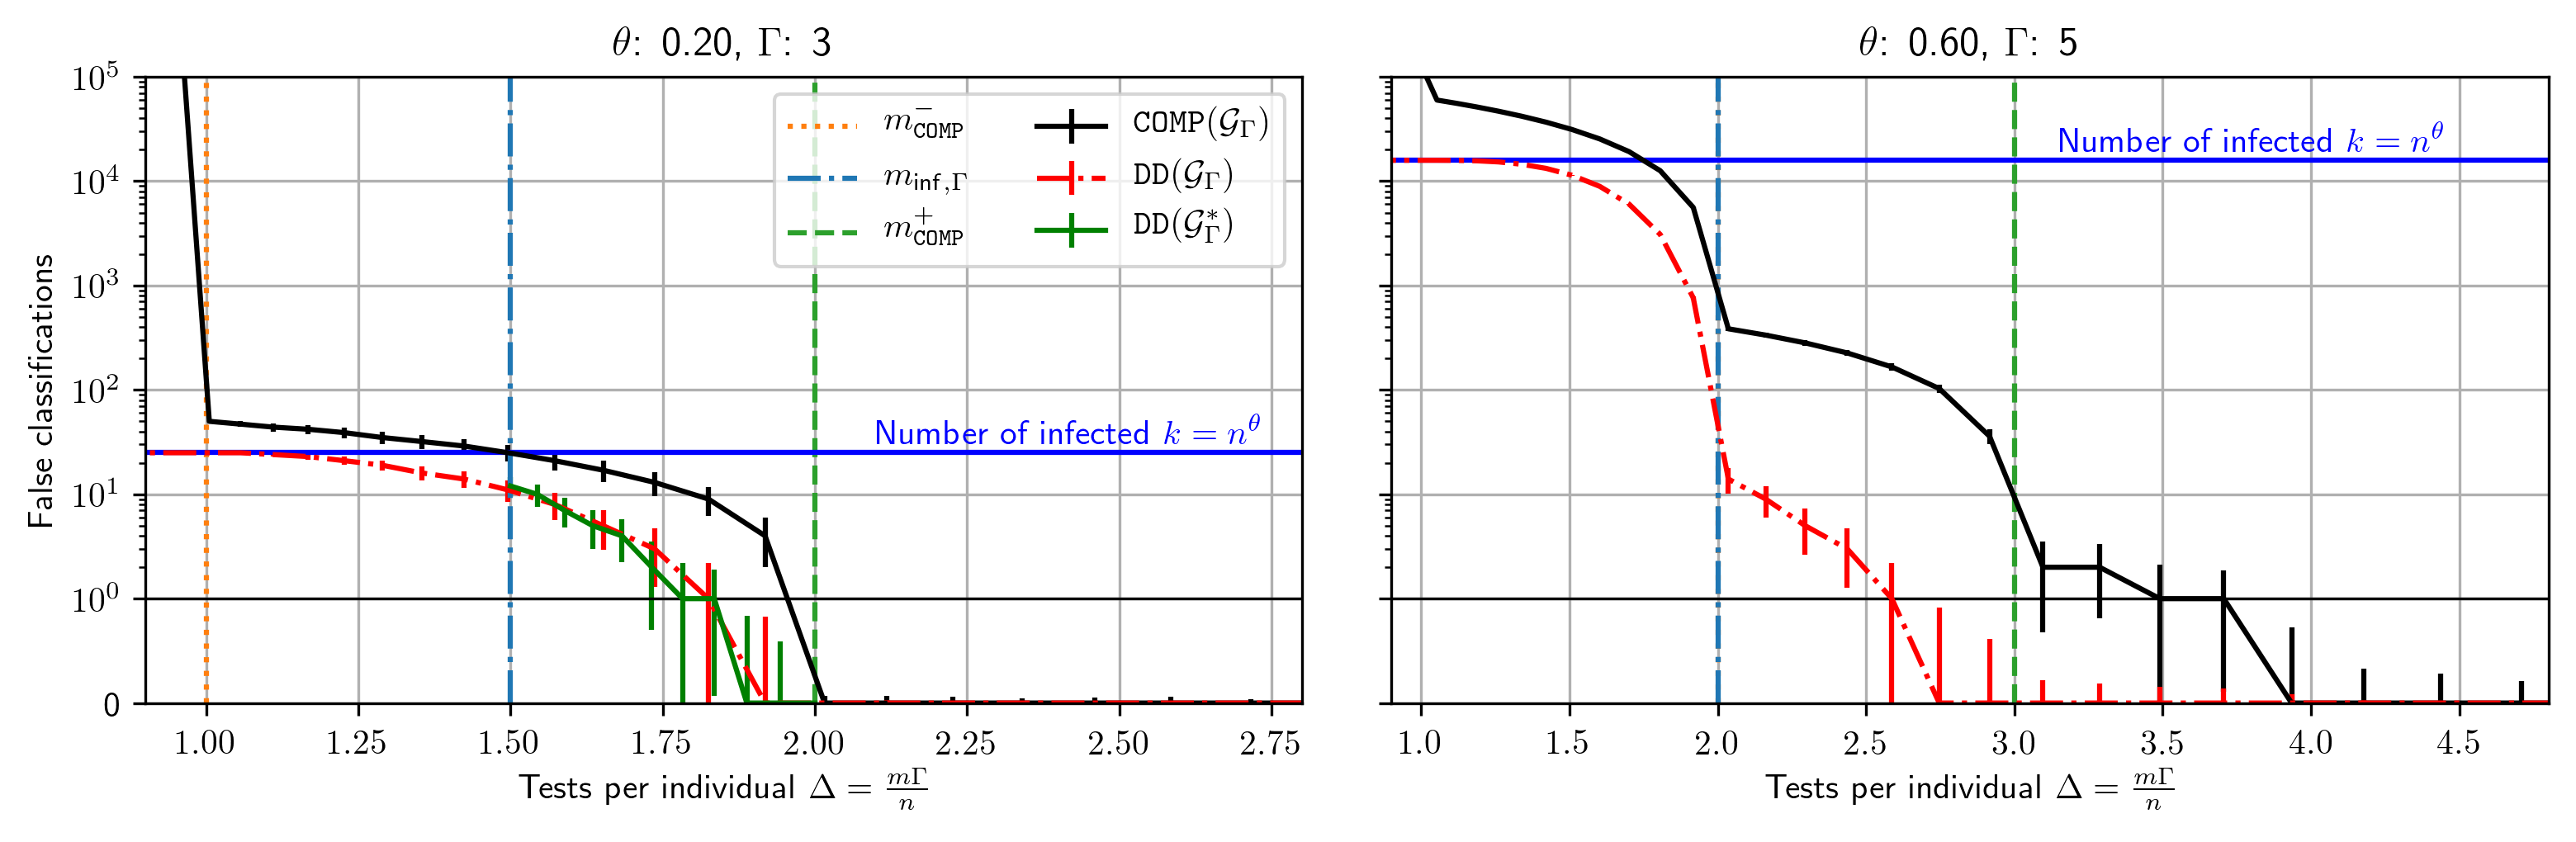

In [2]:
def plot_subfigure(data, n, theta, Gamma, ax, legend = False):
    scale = Gamma / n
    m_inf = max(np.ceil(theta / (1-theta)) * n / Gamma, 2 * n / (Gamma + 1))
    m_comp_minus = func_m_comp_minus(n, theta, Gamma)
    m_comp_plus = func_m_comp_plus(n, theta, Gamma)
    ax.axvline(m_comp_minus * scale,  label=r"$m_{\tt COMP}^-$", ls=":", color="C1")
    ax.axvline(m_inf        * scale,  label=r"$m_{{\sf inf},\Gamma}$", ls="-.", color="C0")
    ax.axvline(m_comp_plus  * scale, label=r"$m_{\tt COMP}^{+}$", ls="--", color="C2")

    ax.set_title(r"$\theta$: %.2f, $\Gamma$: %d" % (theta, Gamma))
    ax.set_xlabel("Tests per individual $\\Delta = \\frac{m \\Gamma}{n}$")
    ax.grid()

    ax.semilogy()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "0" if x < 1 else "$10^{%d}$" % (round(math.log(x, 10)))))

    maxy = 0.0
    maxx = 0

    for ai, (algo, view) in enumerate(data.groupby("algo")):
        if algo == "comp":
            label = r"\texttt{COMP}$(\mathcal G_\Gamma)$"
            key = "fp"
            color = "k"
            ls = "-"
            ax.set_ylim(0.1, n)
        elif algo == "dd":
            label = r"\texttt{DD}$(\mathcal G_\Gamma)$"
            key = "fn"
            color = "r"
            ls = "-."
        else:
            label =  r"\texttt{DD}$(\mathcal G_\Gamma^*)$"
            key = "fn"
            color = "g"
            ls = "-"

        grp = view.groupby("m")
        repeats = grp.size().to_numpy() 
        print(np.min(repeats))
        ys = grp[key].median()
        ys[ys == 0] = 0.1
        ys_err = grp[key].std()
        xs = ys.index

        ax.errorbar(xs* scale, ys, ys_err, color=color, ls=ls, label=label)
        maxy = max(np.max(ys) * 1.1, maxy)
        maxx = max(maxx, max(xs))

    set_log_minors(ax, 0, int(math.ceil(math.log(maxy, 10))))

    if legend:
        ax.set_ylabel("False classifications")
        ax.legend(loc="upper right", ncol=2)
        
    ax.axhline(1, 0, 1, color='k', linewidth=0.8)
    ax.axhline(n ** theta, 0, 1, color='b')
    ax.text(m_comp_plus * scale * 1.05, n ** theta * 1.2, r"Number of infected $k = n^\theta$", color='b' )
    
    ax.set_xlim(0.9, maxx * scale - 0.2)
    ax.set_ylim(0.1, 1e5)
        
sdata = pd.concat([pd.read_csv(f) for f in glob.glob("data/sparse_*")])
sdata.algo[:]="dds"
data = pd.concat([pd.read_csv(f) for f in glob.glob("data/run1e7_*")] + [sdata])
add_error_scores(data)

fig, axs = plt.subplots(1, 2, figsize=(10.5, 3.5), sharey=True, dpi=300)

i = 0
for (n, theta, Gamma), view in data.groupby(["n", "theta", "Gamma"]):
    if not ((theta == 0.2 and Gamma == 3) or (theta == 0.6 and Gamma == 5)):
        continue
    
    plot_subfigure(view, n, theta, Gamma, axs[i], i == 0)
    i += 1

fig.tight_layout()
fig.savefig("consttest_scanm.pdf")



# Finding phase transitions

Based on the idea of instability, we now search the phase transition point: we estimate the peak, search for lower/upper bounds with an instability > 0. 
Technically this is carried out using a binary search which may behave erroneous near the instability region, but the errorbars suggest it's alright; the upper end of the binary search is chosen ~100 times the prediction. So do not take values >> 10 times the predication as absolute, but rather as an indication that something is wrong.

In the following plots, we use the infection parameters $\theta$ as our independent variable and measure the lower / upper bounds; the filled area corresponds to the peaks above. The peak itself is approximated by the average of the lower/upper bound. We also plot the theoretical predictions $m_inf$ and $m_comp$. The dotted line $m_peak / m_pred$ indicates the discrepancy between measured peak $m_peak$ and prediction $m_pred$.

Only nan entries: 31706 (0.7 %)
503850
503850
503850
503850


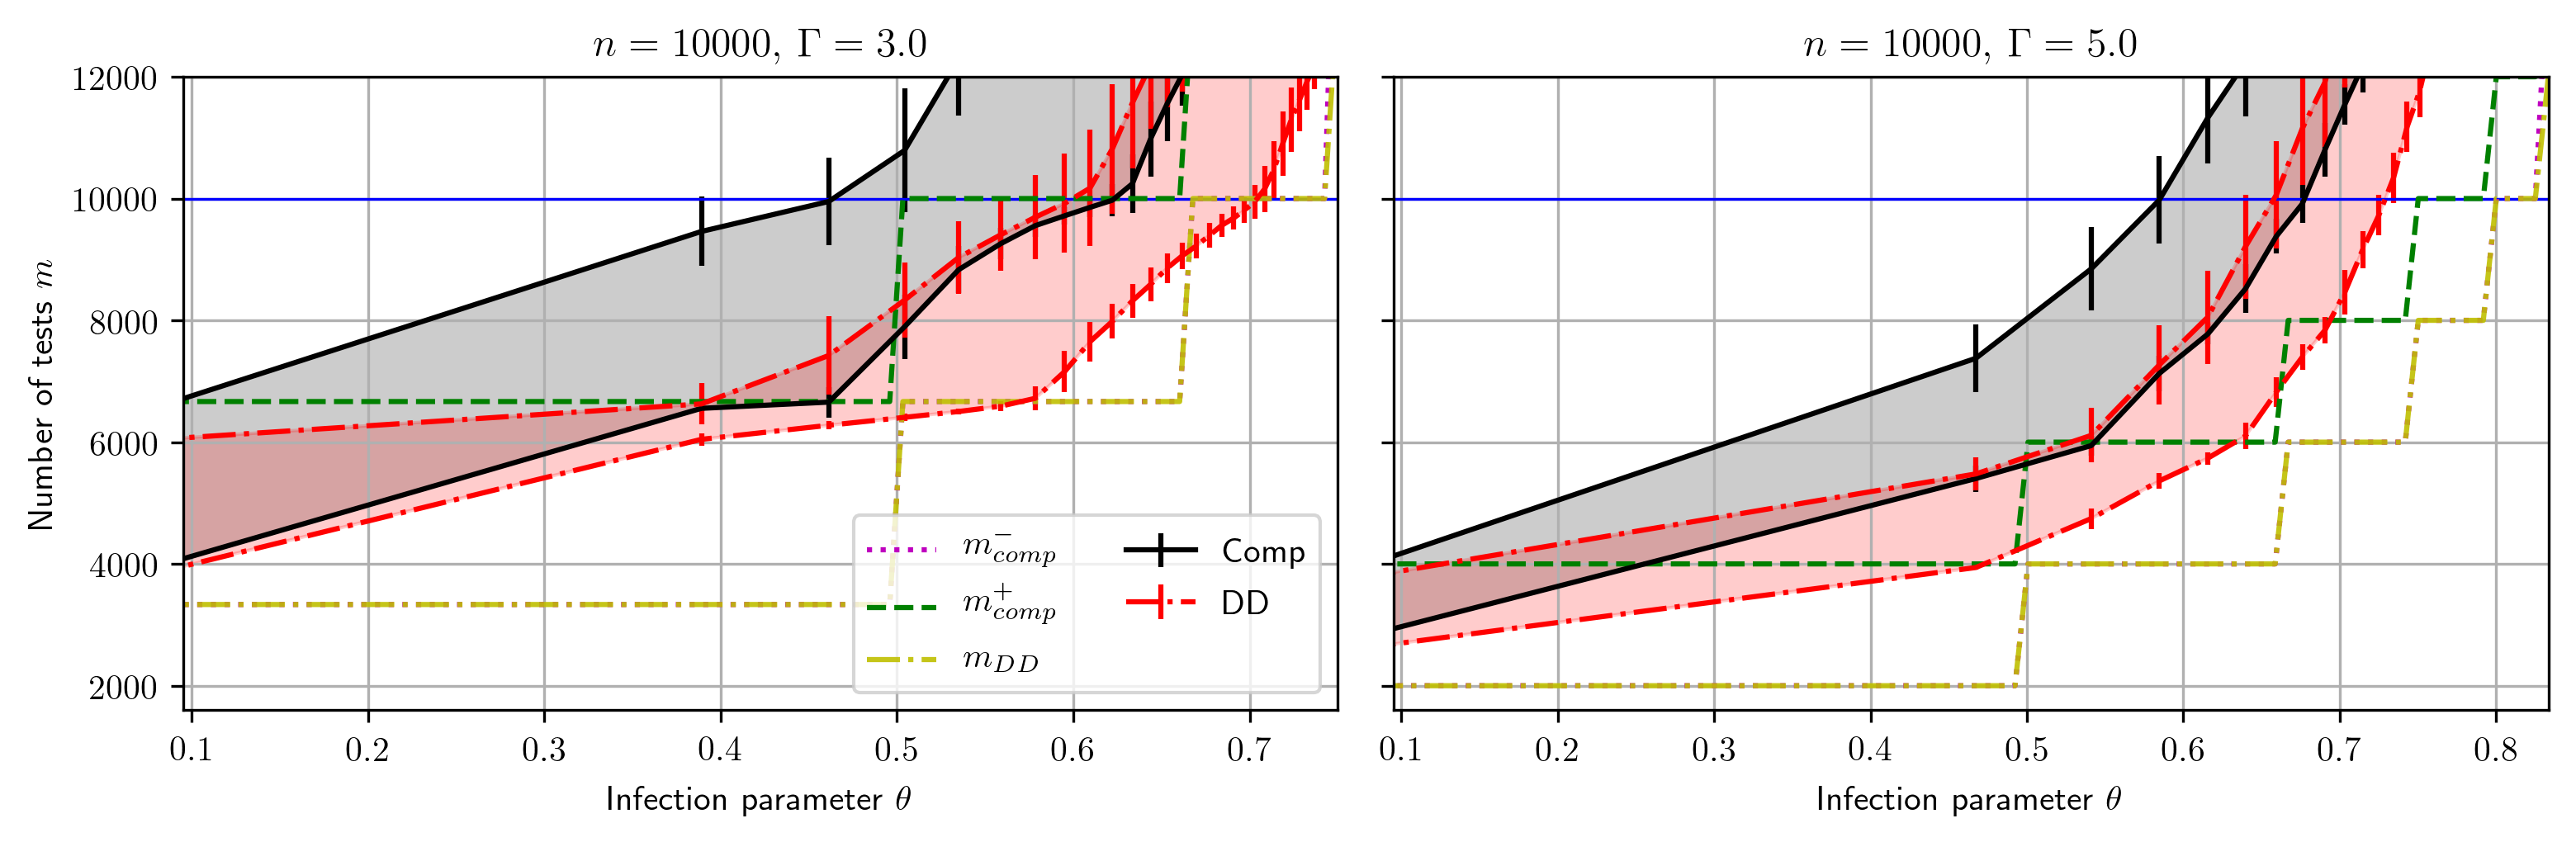

In [3]:
def plot_subfigure(data, n, theta, Gamma, ax, legend):
    ax.set_title("$n=%d,$ $\Gamma=%.1f$" % (n, Gamma))
    
    lss = ["-", "-."]
    colors = ["k", "r"]
    
    theta_max = Gamma / (Gamma + 1)
    theta_clean = np.linspace(0.01, theta_max, num=100)

    #ax.semilogy()
    ax.grid()
    ax.axhline(n, 0, 1, color='b', linewidth=0.8)
    ax.set_xlabel("Infection parameter $\\theta$")
    
    for ai, (algo, view) in enumerate(data.groupby("algo")):
        grp = view.groupby("theta")
        print(np.min(view.m_upper.size))

        mupper = grp.m_upper.median()
        mupper_err = grp.m_upper.std()
        mlower = grp.m_lower.median()
        mlower_err = grp.m_lower.std()

        theta = mupper.index.to_numpy()
        
        algon = "Comp" if algo == "comp" else "DD"

        ax.fill_between(theta, mlower, mupper, color=colors[ai], alpha=0.2)
        #ax.errorbar(theta, (mupper + mlower) * 0.5, color=colors[ai], ls=lss[ai], alpha=0.5)
        ax.errorbar(theta, mupper, mupper_err, color=colors[ai], ls=lss[ai], label=algon)
        ax.errorbar(theta, mlower, mlower_err, color=colors[ai], ls=lss[ai], label=None)

    m_inf = func_m_inf(n, theta_clean, Gamma)
    tc = theta_clean
    ax.plot(tc, func_m_comp_minus(n, tc, Gamma), label="$m_{comp}^-$", ls=":", color="m")
    ax.plot(tc, func_m_comp_plus(n, tc, Gamma), label="$m_{comp}^+$", ls="--", color="g")
    ax.plot(tc, func_m_dd(n, tc, Gamma), label="$m_{DD}$", ls="-.", color="y", alpha=0.9)

    #ax.plot(tc, func_m_dd(n, tc, Gamma), label="$m_{dd}$")
    
    ax.set_xlim(0.095, theta_max)
    ax.set_ylim(np.min(m_inf) * 0.8, 1.2*n  )
    if legend:
        ax.set_ylabel("Number of tests $m$")
        ax.legend(loc="lower right", ncol=2)

# Load data        
data_full = pd.concat([pd.read_csv(f) for f in glob.glob("data/search_*")])
data_full.loc[data_full.m_upper < 0, "m_upper"] = np.nan
data_full.loc[data_full.m_lower < 0, "m_lower"] = np.nan

only_nan = data_full.m_upper.isna() & data_full.m_lower.isna()
num_nan = np.sum(only_nan)
print("Only nan entries: %d (%.1f %%)" % (num_nan, 100.* num_nan / len(only_nan)))
data_full = data_full[~only_nan]        

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10.5, 3.5), sharey=True, dpi=300) 
i = 0
for (n, Gamma), view in data_full.groupby(["n", "Gamma"]):
    if n != 10000: continue
    if Gamma < 3: continue
        
    plot_subfigure(view, n, theta, Gamma, axs[i], i == 0)
    
        
    i += 1

fig.tight_layout()
fig.savefig("consttest_search.pdf")



sample size: [46500, 74400] -> oom: 5
sample size: [46686, 74400] -> oom: 5


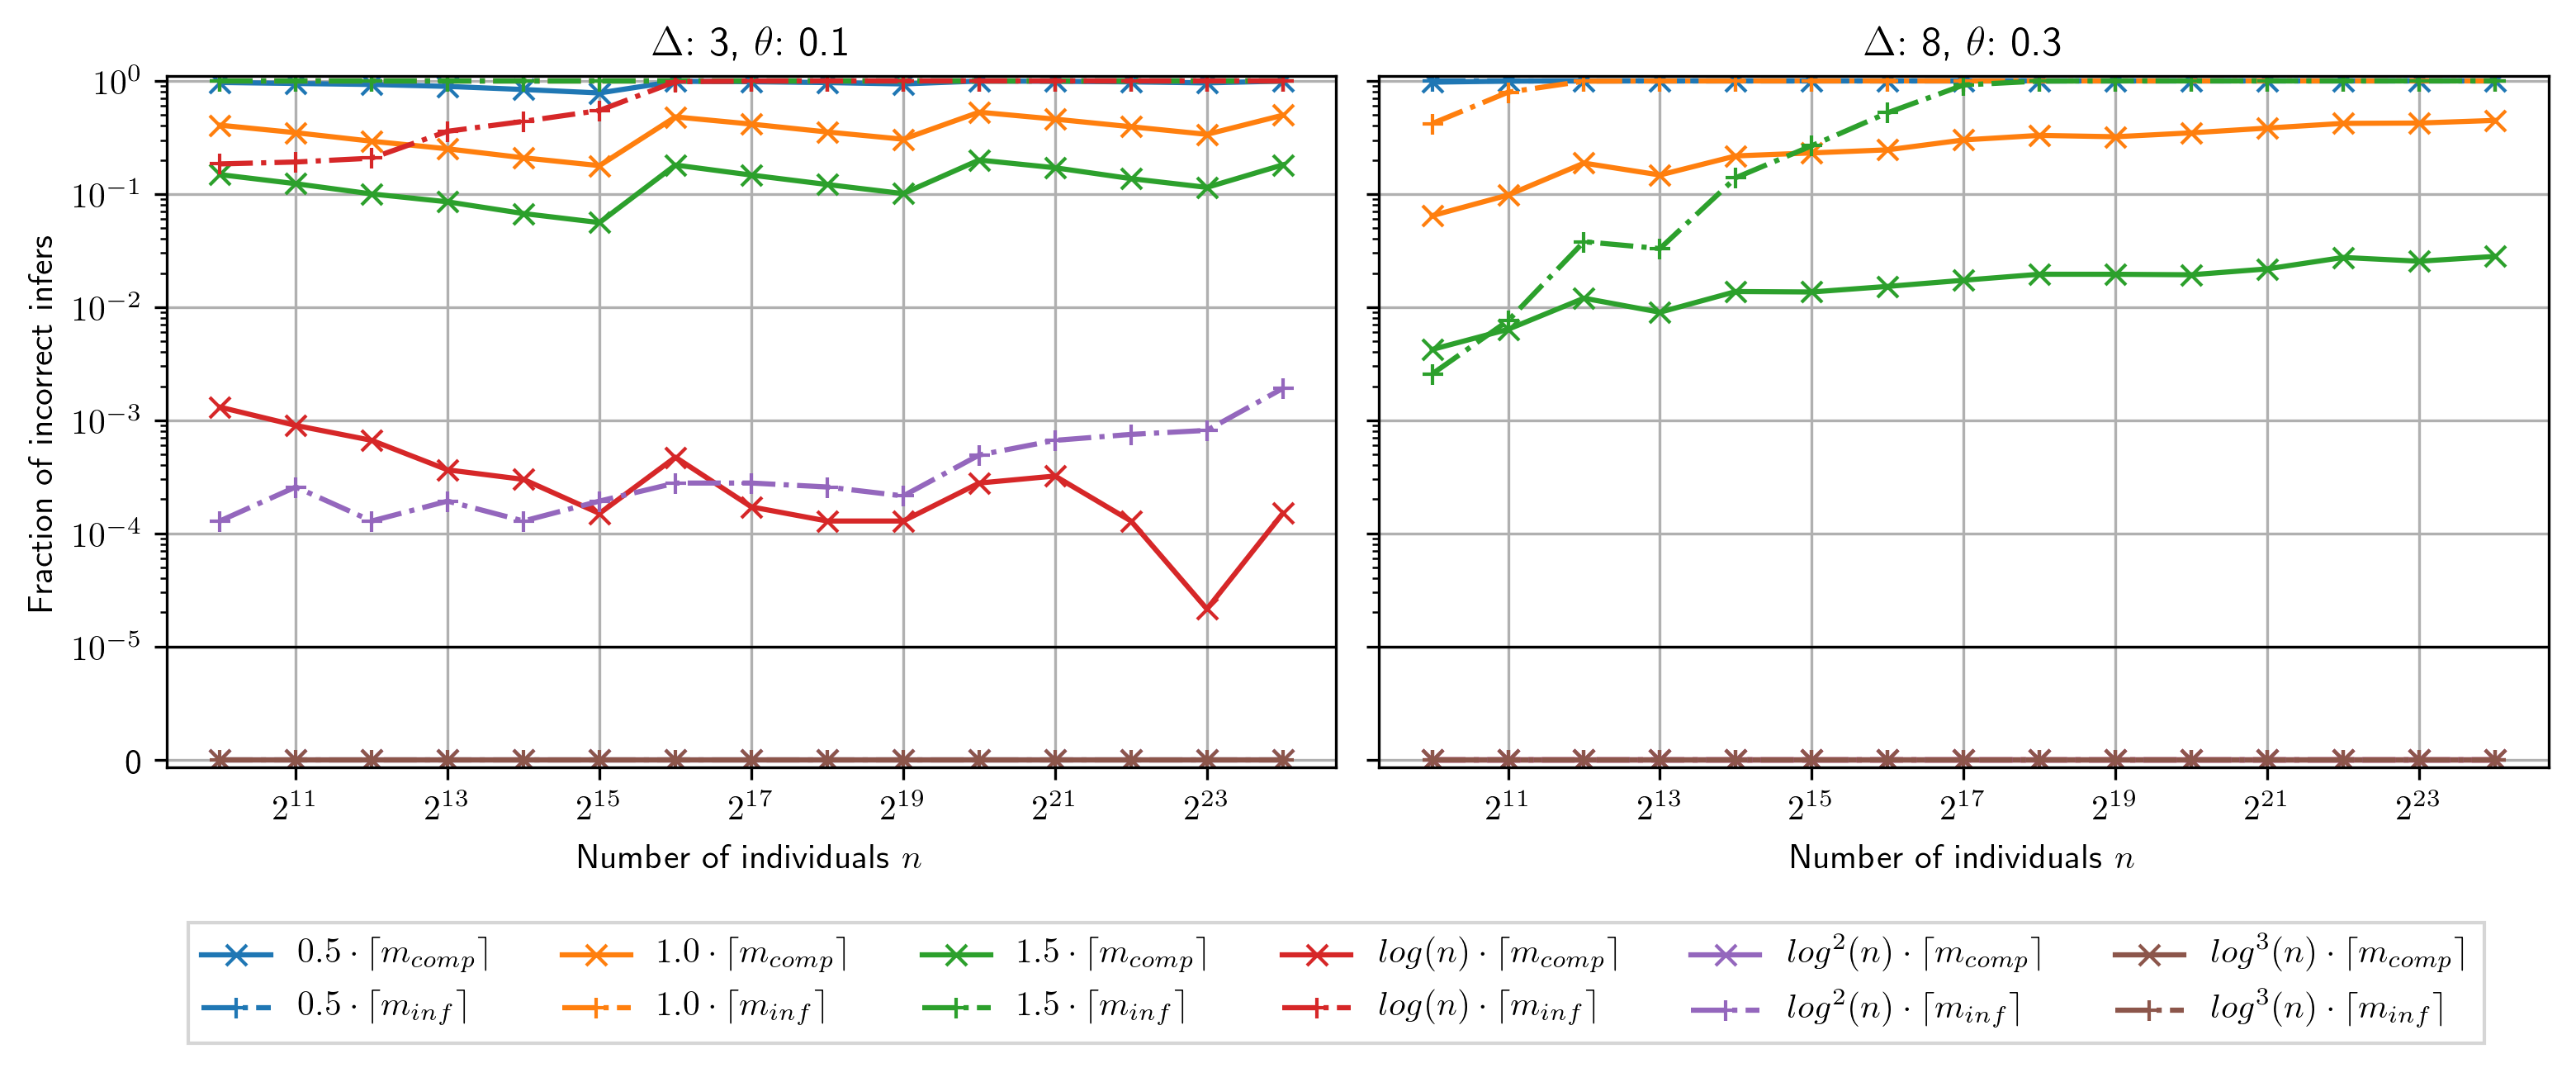

In [4]:
order= ["0.5", "1.0", "1.5", "log(n)", "log^2(n)", "log^3(n)"]

def plot_subfigure(data, theta, Delta, ax, legend):
    mins = np.inf
    maxs = 0
    for (algo), view in data.groupby(["algo"]):
        # Compute counts
        for eps, sview in view.groupby("series"):
            grp = sview.groupby("n")
            mins = min(mins, grp.is_false.size().min())
            maxs = max(maxs, grp.is_false.size().max())
            
    oom = math.ceil(math.log(maxs, 10))
    correct = 0.1 / 10 ** oom

    ax.grid()
    ax.loglog(basex=2)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "0" if x <= correct else "$10^{%d}$" % (round(math.log(x, 10)))))
    set_log_minors(ax, -oom, 0)
        
    for (algo), view in data.groupby(["algo"]):
        ls = "-" if algo == "comp" else "-."
        ms = "x" if algo == "comp" else "+"
        
        for eps, sview in view.groupby("series"):
            if "1.2" == eps: continue
            grp = sview.groupby("n")
            ys = grp.is_false.sum() / grp.is_false.size()
            ys[ys < correct] = correct
            xs = ys.index

            basefkt = "\\lceil m_{%s} \\rceil" % ("comp" if algo == "comp" else "inf")
            labelpref = eps
            if "log" in labelpref: labelpref += "(n)"

            color = 'C%d' % order.index(labelpref)
            ax.plot(xs, ys, linestyle=ls, marker=ms, color = color,
                    label="$%s \cdot %s$" % (labelpref, basefkt))

    ax.set_title("$\\Delta\\colon$ %d, $\\theta\\colon$ %.1f" % (Delta, theta))
    print("sample size: [%d, %d] -> oom: %d" % (mins, maxs, oom))
    
    # Tweak axes
    ax.axhline(0.1 ** oom, 0, 1, color='k', linewidth=0.8)
    ax.set_ylim(correct * 0.85, 1.1)

    ax.set_xlabel("Number of individuals $n$")

    if legend:
        ax.set_ylabel("Fraction of incorrect infers")

# Load data
data = pd.concat([pd.read_csv(f) for f in glob.glob("data/scanres_*")])
data = data[data.series != "loglog"]
add_error_scores(data)

# Prepare plots        
fig, axs = plt.subplots(1, 2, figsize=(10.5, 4.5), sharey=True, dpi=300) 
i = 0
for (Delta, theta), view in data.groupby(["Delta", "theta"]):
    if not ((Delta == 3 and theta == 0.1) or (Delta == 8 and theta == 0.3)):
        continue
        
    plot_subfigure(view, theta, Delta, axs[i], i == 0)
    i += 1

fig.tight_layout()
fig.subplots_adjust(bottom=0.3) #, wspace=0.33)

# order and place legend
ax = axs[0]
handles, labels = ax.get_legend_handles_labels()
s = sorted(zip(labels, handles), key=lambda t: 1 * ("inf" in t[0]) + 1000 * order.index(t[0].split(r' ')[0][1:].strip()))
labels, handles = zip(*s)
ax.legend(handles, labels, ncol=6,
          loc='upper center',  bbox_to_anchor=(1, -0.2),fancybox=False, shadow=False)
    
fig.savefig("constres_scann.pdf")
        

In [7]:
data = pd.concat([pd.read_csv(f) for f in glob.glob("data/conv_*")])
data = data[~np.isnan(data.k)]
add_error_scores(data)


comp Gamma: 5.0  theta: 0.2
  opt:  [ 8.95393265 -0.55727604] cov: [[ 2.19117889e+00 -2.61015035e-02]
 [-2.61015035e-02  3.22238683e-04]]
  exp:  [16.0, -1.4000000000000001]
comp Gamma: 5.0  theta: 0.5
  opt:  [46.70595828 -0.47509944] cov: [[ 1.83923269e+00 -4.06997659e-03]
 [-4.06997659e-03  9.37148276e-06]]
  exp:  [64.0, -1.0]
comp Gamma: 5.0  theta: 0.6
  opt:  [41.12469564 -0.16966783] cov: [[ 2.74443909e+00 -5.81541829e-03]
 [-5.81541829e-03  1.30631539e-05]]
  exp:  [64.0, -0.6000000000000002]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


dd Gamma: 5.0  theta: 0.5
  opt:  [166.83631005  -0.43204004] cov: [[ 2.25552271e+02 -1.35281943e-01]
 [-1.35281943e-01  8.51143715e-05]]
  exp:  [16.0, 0.0]
dd Gamma: 5.0  theta: 0.6
  opt:  [ 1.72794564e+02 -1.46803092e-01] cov: [[ 1.95010081e+02 -8.71916217e-02]
 [-8.71916217e-02  4.01749695e-05]]
  exp:  [16.0, 0.19999999999999996]


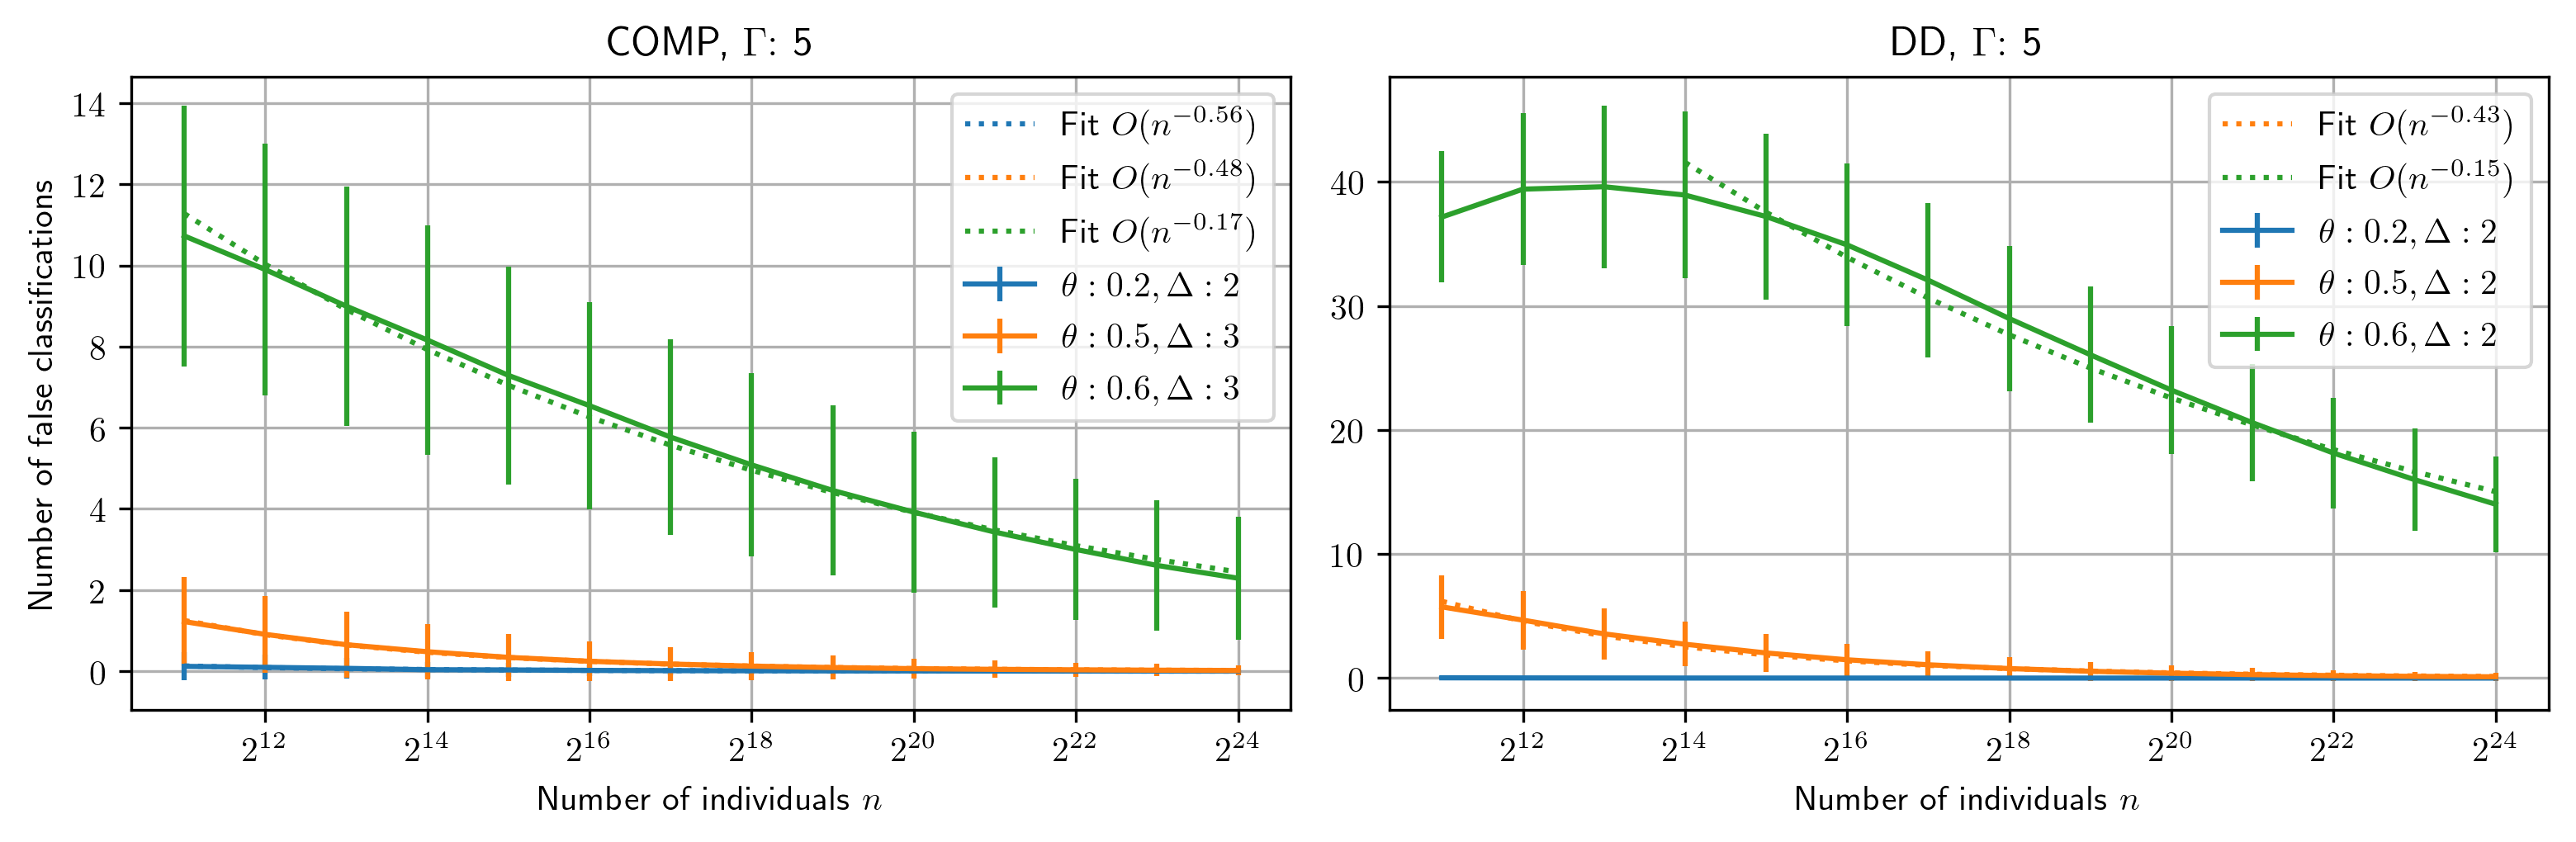

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10.5, 3.5), dpi=300) 

def conv_comp(x, a, b):
    return a * x ** b

for aid, (algo, aview) in enumerate(data[data.n > 2000].groupby("algo")):
    for gid, (Gamma, gview) in enumerate(aview.groupby("Gamma")):
        if Gamma == 3: continue
        ax = axs[aid] #, gid]
        for tid, (theta, view) in enumerate(gview.groupby("theta")):
            Delta = view.Delta.unique()
            assert(len(Delta) == 1)
            Delta = Delta[0]

            label = r"$\theta: %.1f, \Delta: %d$" % (theta, Delta)
            color = "C%d" % tid
            grp = view.groupby("n")
            
            
            ys     = grp.false.mean()
            ys_err = grp.false.std()
            xs = np.array(ys.index)
            ys, ys_err = np.array(ys), np.array(ys_err)

            ax.errorbar(xs, ys, ys_err, label=label, color=color)
            
            if np.max(ys) < 0.1:
                continue
                
            maxx = np.argmax(ys)
            maxx += (maxx > 0)

            expected = [(Gamma-1)**Delta, 1 - (1-theta)*Delta]
            if algo == "comp":
                expected[1] = theta - (1-theta)*Delta
            print(algo, "Gamma:", Gamma, " theta:", theta)
            
            popt, pcov = curve_fit(conv_comp, xs[maxx:], ys[maxx:], expected, sigma=ys_err[maxx:], absolute_sigma=False)
            perr = np.sqrt(np.diag(pcov))
            print("  opt: ", popt, "cov:", pcov)
            print("  exp: ", expected)

            ys_fit = conv_comp(xs[maxx:], *popt)
            ax.plot(xs[maxx:], ys_fit, color=color, linestyle=":", label="Fit $O(n^{%.2f})$" % (popt[1]))
                
                
 
        ax.set_title(r"%s, $\Gamma\colon$ %d" % (algo.upper(), Gamma))
        ax.legend()
        ax.semilogx(basex=2)
        ax.grid()

for i in range(2):
    axs[i].set_xlabel("Number of individuals $n$")
axs[0].set_ylabel("Number of false classifications")
        
    
fig.tight_layout()
fig.savefig("convergence.pdf")

        